<a href="https://colab.research.google.com/github/avocadopelvis/deep-music/blob/main/deep-music-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.model_selection import train_test_split

import music21
from music21 import *

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

# import os
# import sys
# import warnings
# warnings.filterwarnings("ignore")
# warnings.simplefilter("ignore")
# np.random.seed(42)

import json
import random
import IPython
from IPython.display import Image, Audio
# from collections import Counter

In [13]:
# load corpus
with open("/content/drive/MyDrive/ML PROJECT/data.txt", 'r') as f:
  corpus = json.load(f)

### Create a list of sorted unique characters

In [14]:
# store all the unique characters in the corpus to a mapping dictionary
symbol = sorted(list(set(corpus)))

corpus_len = len(corpus)
symbol_len = len(symbol)

# build a dictionary to access the vocabulary from indices & vice versa
map = dict((c, i) for i, c in enumerate(symbol))
reverse_map = dict((i, c) for i, c in enumerate(symbol))

print("Total number of characters:", corpus_len)
print("Number of unique characters:", symbol_len)

Total number of characters: 59855
Number of unique characters: 228


### Encode & split the corpus as labels & targets

In [15]:
length = 40
features = []
targets = []

for i in range(0, corpus_len - length, 1):
  feature = corpus[i:i+length]
  target = corpus[i+length]
  features.append([map[j] for j in feature])
  targets.append(map[target])

datapoints_len = len(targets)
print("Total number of sequences in the corpus:", datapoints_len)

Total number of sequences in the corpus: 59815


In [16]:
# reshape X & normalize
X = (np.reshape(features, (datapoints_len, length, 1))) / float(symbol_len)

# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets)

Splitting train & seed datasets

In [17]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
rate = 0.1
learning_rate = 0.01
optimizer = Adamax(learning_rate = learning_rate)
loss = 'categorical_crossentropy'
batch_size = 256
epochs = 200

### MODEL

In [19]:
model = Sequential()
model.add(LSTM(512, input_shape = (X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(rate = rate))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(rate = rate))
model.add(Dense(y.shape[1], activation = 'softmax'))

model.compile(loss = loss, optimizer = optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 228)               58596     
                                                                 
Total params: 1,964,516
Trainable params: 1,964,516
No

In [20]:
# train the model
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/200
187/187 [==============================] - 12s 50ms/step - loss: 4.5181
Epoch 2/200
187/187 [==============================] - 9s 48ms/step - loss: 4.4313
Epoch 3/200
187/187 [==============================] - 9s 46ms/step - loss: 4.4243
Epoch 4/200
187/187 [==============================] - 9s 47ms/step - loss: 4.4157
Epoch 5/200
187/187 [==============================] - 9s 46ms/step - loss: 4.4057
Epoch 6/200
187/187 [==============================] - 9s 46ms/step - loss: 4.3466
Epoch 7/200
187/187 [==============================] - 9s 46ms/step - loss: 4.3167
Epoch 8/200
187/187 [==============================] - 8s 45ms/step - loss: 4.3047
Epoch 9/200
187/187 [==============================] - 8s 45ms/step - loss: 4.3004
Epoch 10/200
187/187 [==============================] - 9s 46ms/step - loss: 4.2924
Epoch 11/200
187/187 [==============================] - 8s 45ms/step - loss: 4.2865
Epoch 12/200
187/187 [==============================] - 9s 46ms/step - loss: 4.2827


### Evaluate Model

[Text(0.5, 0, 'Epochs')]

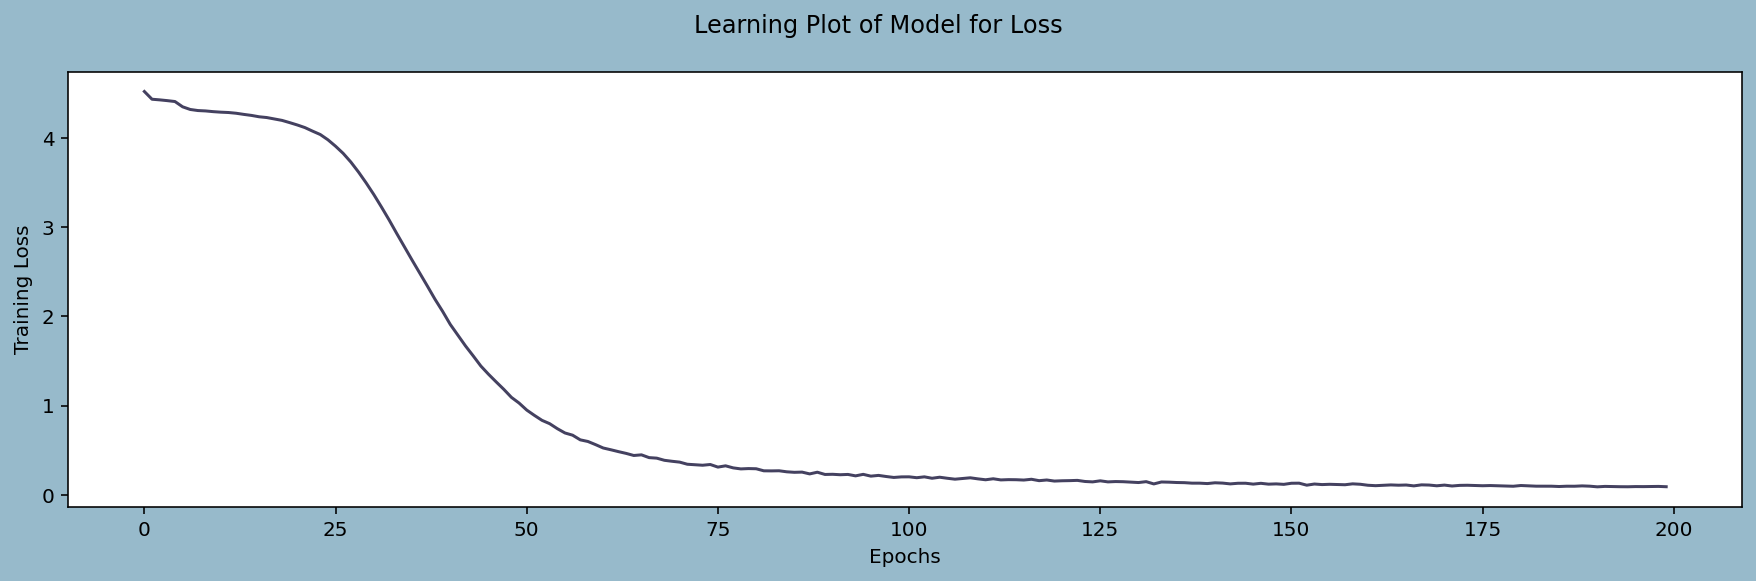

In [21]:
# plot the learning curve for the loss function
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl= sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel = "Training Loss")
pl.set(xlabel = "Epochs")

In [23]:
# function to display music sheet
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chord_n_notes(snippet):
    melody = []
    offset = 0
    for i in snippet:
        # if it is chord
        if "." in i or i.isdigit():
            # seperate the notes in chords
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        # if it is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    
    melody_midi = stream.Stream(melody)
    return melody_midi

In [24]:
# function to generate music
def melody_generator(note_count):
  seed = X_seed[np.random.randint(0, len(X_seed) - 1)]
  music = ""
  notes = []
  for i in range(note_count):
    seed = seed.reshape(1, length, 1)
    prediction = model.predict(seed, verbose = 0)[0]
    prediction = np.log(prediction) / 1.0
    exp_preds = np.exp(prediction)
    prediction = exp_preds/np.sum(exp_preds)

    index = np.argmax(prediction)
    index_N = index/float(symbol_len)
    notes.append(index)
    music = [reverse_map[char] for char in notes]

    # seed = np.insert(seed[0], len(seed[0]), index_N)
    # seed = seed[1:]

  melody = chords_n_notes(music)
  midi = stream.Stream(melody)
  return music, midi

  music_notes, melody = melody_generator(100)
  show(melody)